###################### Part 1 ##############################

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

In [25]:
from statsmodels.regression.linear_model  import  OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [27]:
#прочитать csv матаданные
nifty_meta = pd.read_csv('data/nifty_meta.csv')
nifty_meta.head(4)

,Company Name,Industry,Symbol,Series,ISIN Code
0,ACC Ltd.,CEMENT & CEMENT PRODUCTS,ACC,EQ,INE012A01025
1,Adani Ports and Special Economic Zone Ltd.,SERVICES,ADANIPORTS,EQ,INE742F01042
2,Adani Transmission Ltd.,POWER,ADANITRANS,EQ,INE931S01010
3,Ambuja Cements Ltd.,CEMENT & CEMENT PRODUCTS,AMBUJACEM,EQ,INE079A01024


In [28]:
#получить список тикеров с отраслью, равной FINANCIAL SERVICES
tickers = list(nifty_meta[nifty_meta.Industry == 'FINANCIAL SERVICES'].Symbol)
print(tickers)
print(len(tickers))

['AXISBANK', 'BAJFINANCE', 'BAJAJFINSV', 'BAJAJHLDNG', 'BANDHANBNK', 'BANKBARODA', 'GICRE', 'HDFCAMC', 'HDFCBANK', 'HDFCLIFE', 'HDFC', 'ICICIBANK', 'ICICIGI', 'ICICIPRULI', 'IBULHSGFIN', 'INDUSINDBK', 'KOTAKBANK', 'L&TFH', 'PEL', 'PFC', 'PNB', 'SBILIFE', 'SRTRANSFIN', 'SBIN', 'NIACL']
25


In [29]:
# даты начала и окончания тестирования
fromdate = datetime.datetime(2010, 1, 1)
todate =datetime.datetime(2020, 6, 15)

In [30]:
# прочитать данные о ценах
prices = pd.read_csv('data/prices.csv',index_col=['ticker', 'date'], parse_dates=True)
prices.head(5)

open        high         low       close
ticker   date                                                      
AXISBANK 2010-01-04  198.779999  199.990005  197.619995  140.712021
         2010-01-05  199.600006  204.000000  199.139999  143.647934
         2010-01-06  204.000000  205.740005  198.509995  141.236801
         2010-01-07  199.289993  201.199997  197.820007  142.236725
         2010-01-08  200.600006  203.979996  199.270004  144.094727

In [31]:
# удалить тикеры, если у нас есть данные менее чем за 10 лет.
min_obs = 2520
nobs = prices.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index

In [32]:
prices = prices.loc[idx[keep,:], :]
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 38580 entries, ('AXISBANK', Timestamp('2010-01-04 00:00:00')) to ('SRTRANSFIN', Timestamp('2020-06-15 00:00:00'))
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    38579 non-null  float64
 1   high    38579 non-null  float64
 2   low     38579 non-null  float64
 3   close   38579 non-null  float64
dtypes: float64(4)
memory usage: 1.4+ MB


In [33]:
# окончательный список
TICKERS = list(prices.index.get_level_values('ticker').unique())
print(len(TICKERS))
print(TICKERS)

15
['AXISBANK', 'BAJAJFINSV', 'BAJAJHLDNG', 'BAJFINANCE', 'BANKBARODA', 'HDFC', 'HDFCBANK', 'ICICIBANK', 'INDUSINDBK', 'KOTAKBANK', 'PEL', 'PFC', 'PNB', 'SBIN', 'SRTRANSFIN']


In [34]:
# распаковать и взять цену закрытия
close = prices.unstack('ticker')['close'].sort_index()
close = close.dropna()
close.head(2)

ticker,AXISBANK,BAJAJFINSV,BAJAJHLDNG,BAJFINANCE,BANKBARODA,HDFC,HDFCBANK,ICICIBANK,INDUSINDBK,KOTAKBANK,PEL,PFC,PNB,SBIN,SRTRANSFIN
date,,,,,,,,,,,,,,,
2010-01-04,140.712021,347.934143,494.222076,16.031584,51.206989,429.764343,134.245209,85.319977,133.753540,202.426041,252.234650,61.325417,84.943443,95.066895,421.881561
2010-01-05,143.647934,348.708527,498.012665,15.924150,52.686508,431.226868,134.363205,86.130264,133.613098,204.430389,253.638733,62.669540,86.255913,95.102180,424.757904


In [35]:
# разбить тестовый
train_close, test_close = train_test_split(close, test_size=0.5,shuffle=False)

In [36]:
# быстрый просмотр головы и хвоста поезда set
train_close.head(2).append(train_close.tail(2))

/tmp/ipykernel_23105/4092566699.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_close.head(2).append(train_close.tail(2))


ticker,AXISBANK,BAJAJFINSV,BAJAJHLDNG,BAJFINANCE,BANKBARODA,HDFC,HDFCBANK,ICICIBANK,INDUSINDBK,KOTAKBANK,PEL,PFC,PNB,SBIN,SRTRANSFIN
date,,,,,,,,,,,,,,,
2010-01-04,140.712021,347.934143,494.222076,16.031584,51.206989,429.764343,134.245209,85.319977,133.753540,202.426041,252.234650,61.325417,84.943443,95.066895,421.881561
2010-01-05,143.647934,348.708527,498.012665,15.924150,52.686508,431.226868,134.363205,86.130264,133.613098,204.430389,253.638733,62.669540,86.255913,95.102180,424.757904
2015-03-18,565.011414,1429.524780,1232.434326,373.762146,176.891403,746.211670,504.396698,281.529602,876.665283,668.962646,776.118347,101.667664,164.392944,277.530243,1108.600708
2015-03-19,547.805969,1404.615723,1244.039917,372.603363,171.310471,746.211670,499.013824,277.661316,855.263062,660.394348,777.710266,100.663200,157.955719,272.024109,1115.327637


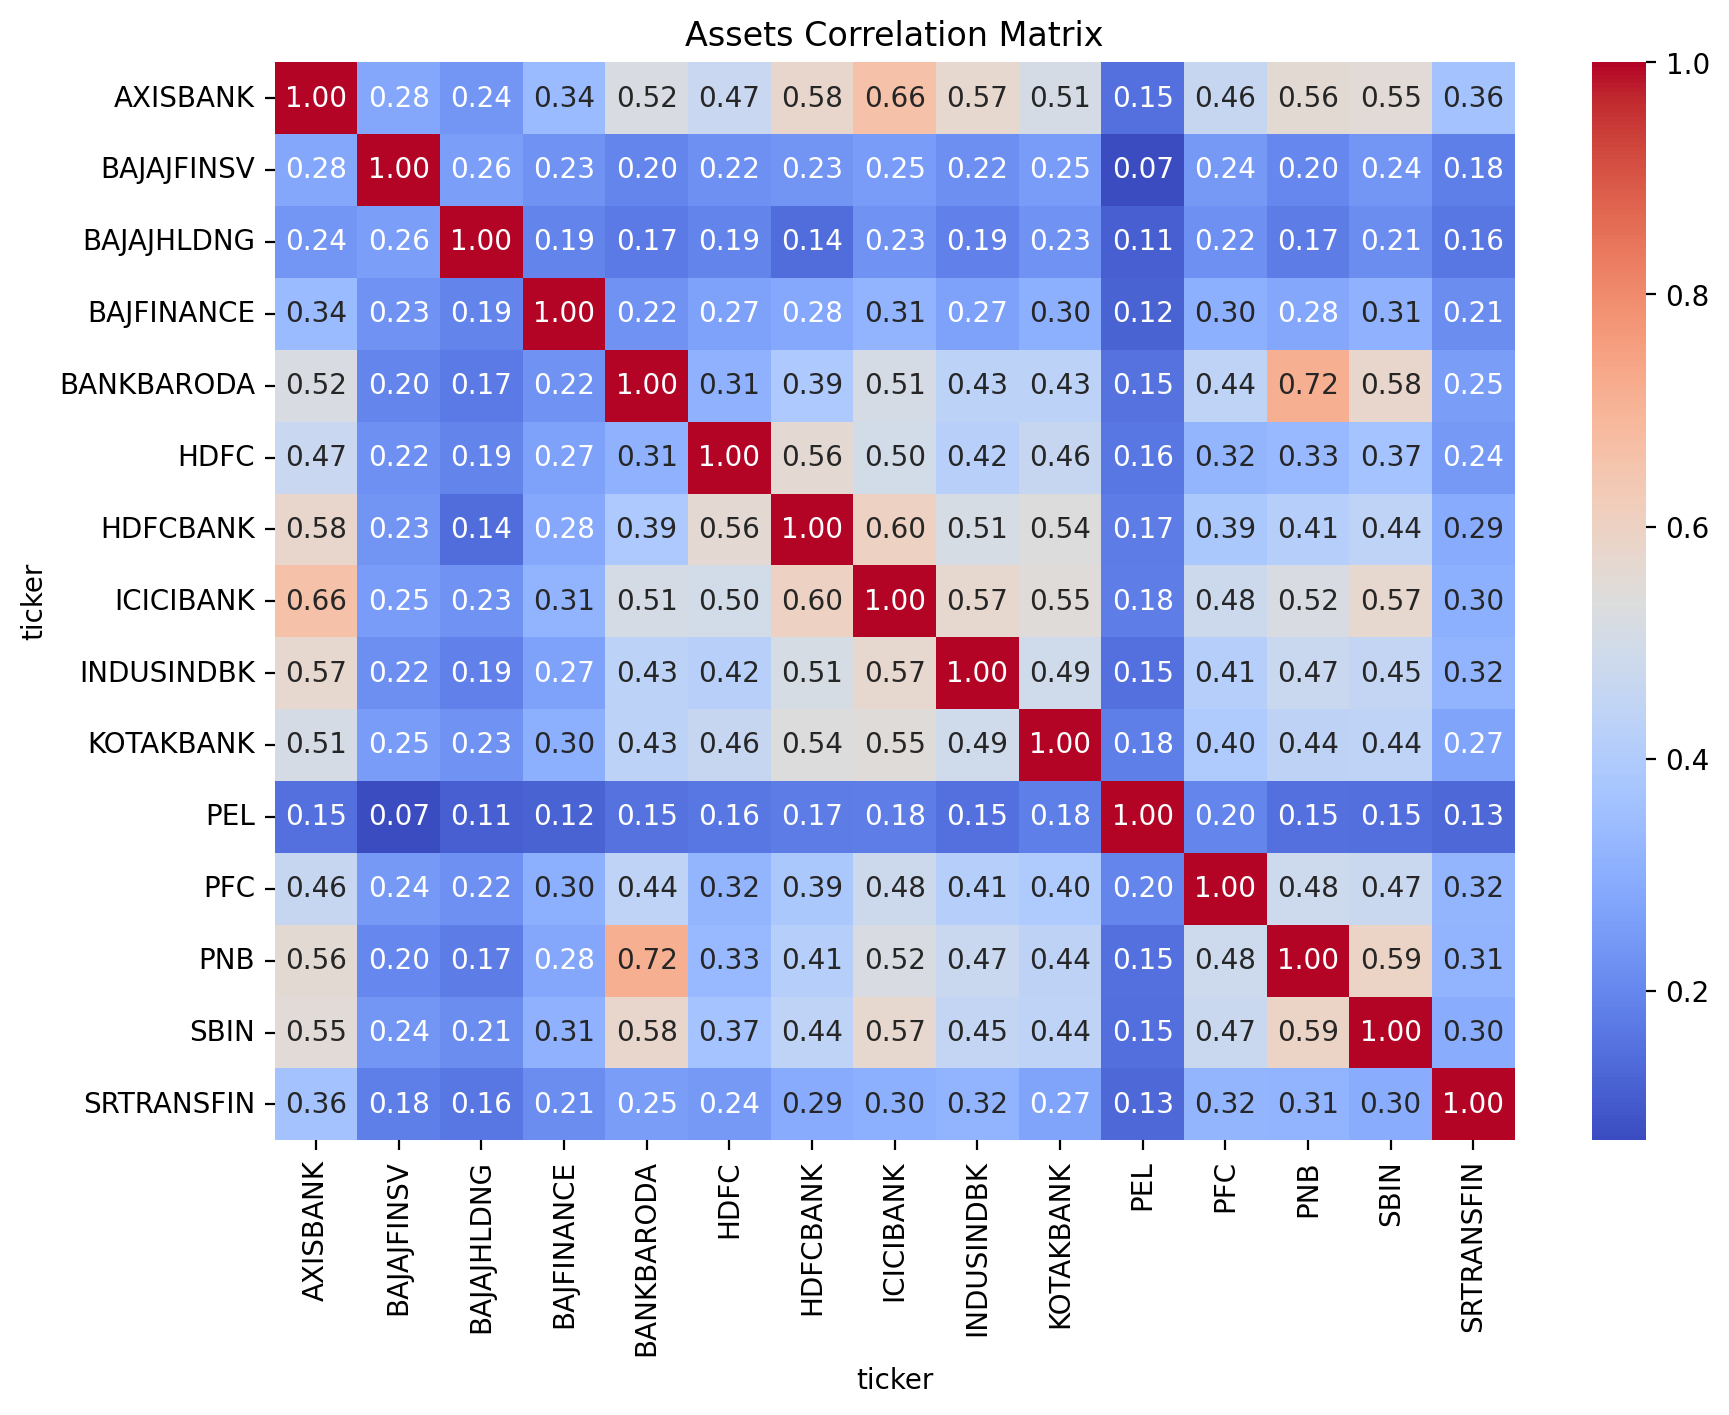

In [37]:
# Корреляция Пирсона, чтобы получить общее представление об отношениях
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax,
cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('images/chart1', dpi=300)

In [38]:
# функция для поиска коинтегрированных
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('AXISBANK', 'PEL'), ('AXISBANK', 'SRTRANSFIN'), ('BAJAJFINSV', 'HDFCBANK'), ('BAJAJFINSV', 'INDUSINDBK'), ('BAJAJFINSV', 'KOTAKBANK'), ('BAJAJHLDNG', 'ICICIBANK'), ('BAJAJHLDNG', 'SBIN'), ('BAJFINANCE', 'KOTAKBANK'), ('BANKBARODA', 'ICICIBANK'), ('BANKBARODA', 'SBIN'), ('BANKBARODA', 'SRTRANSFIN'), ('ICICIBANK', 'PEL'), ('ICICIBANK', 'SBIN'), ('INDUSINDBK', 'KOTAKBANK'), ('INDUSINDBK', 'PEL'), ('KOTAKBANK', 'PEL'), ('PEL', 'SBIN')]


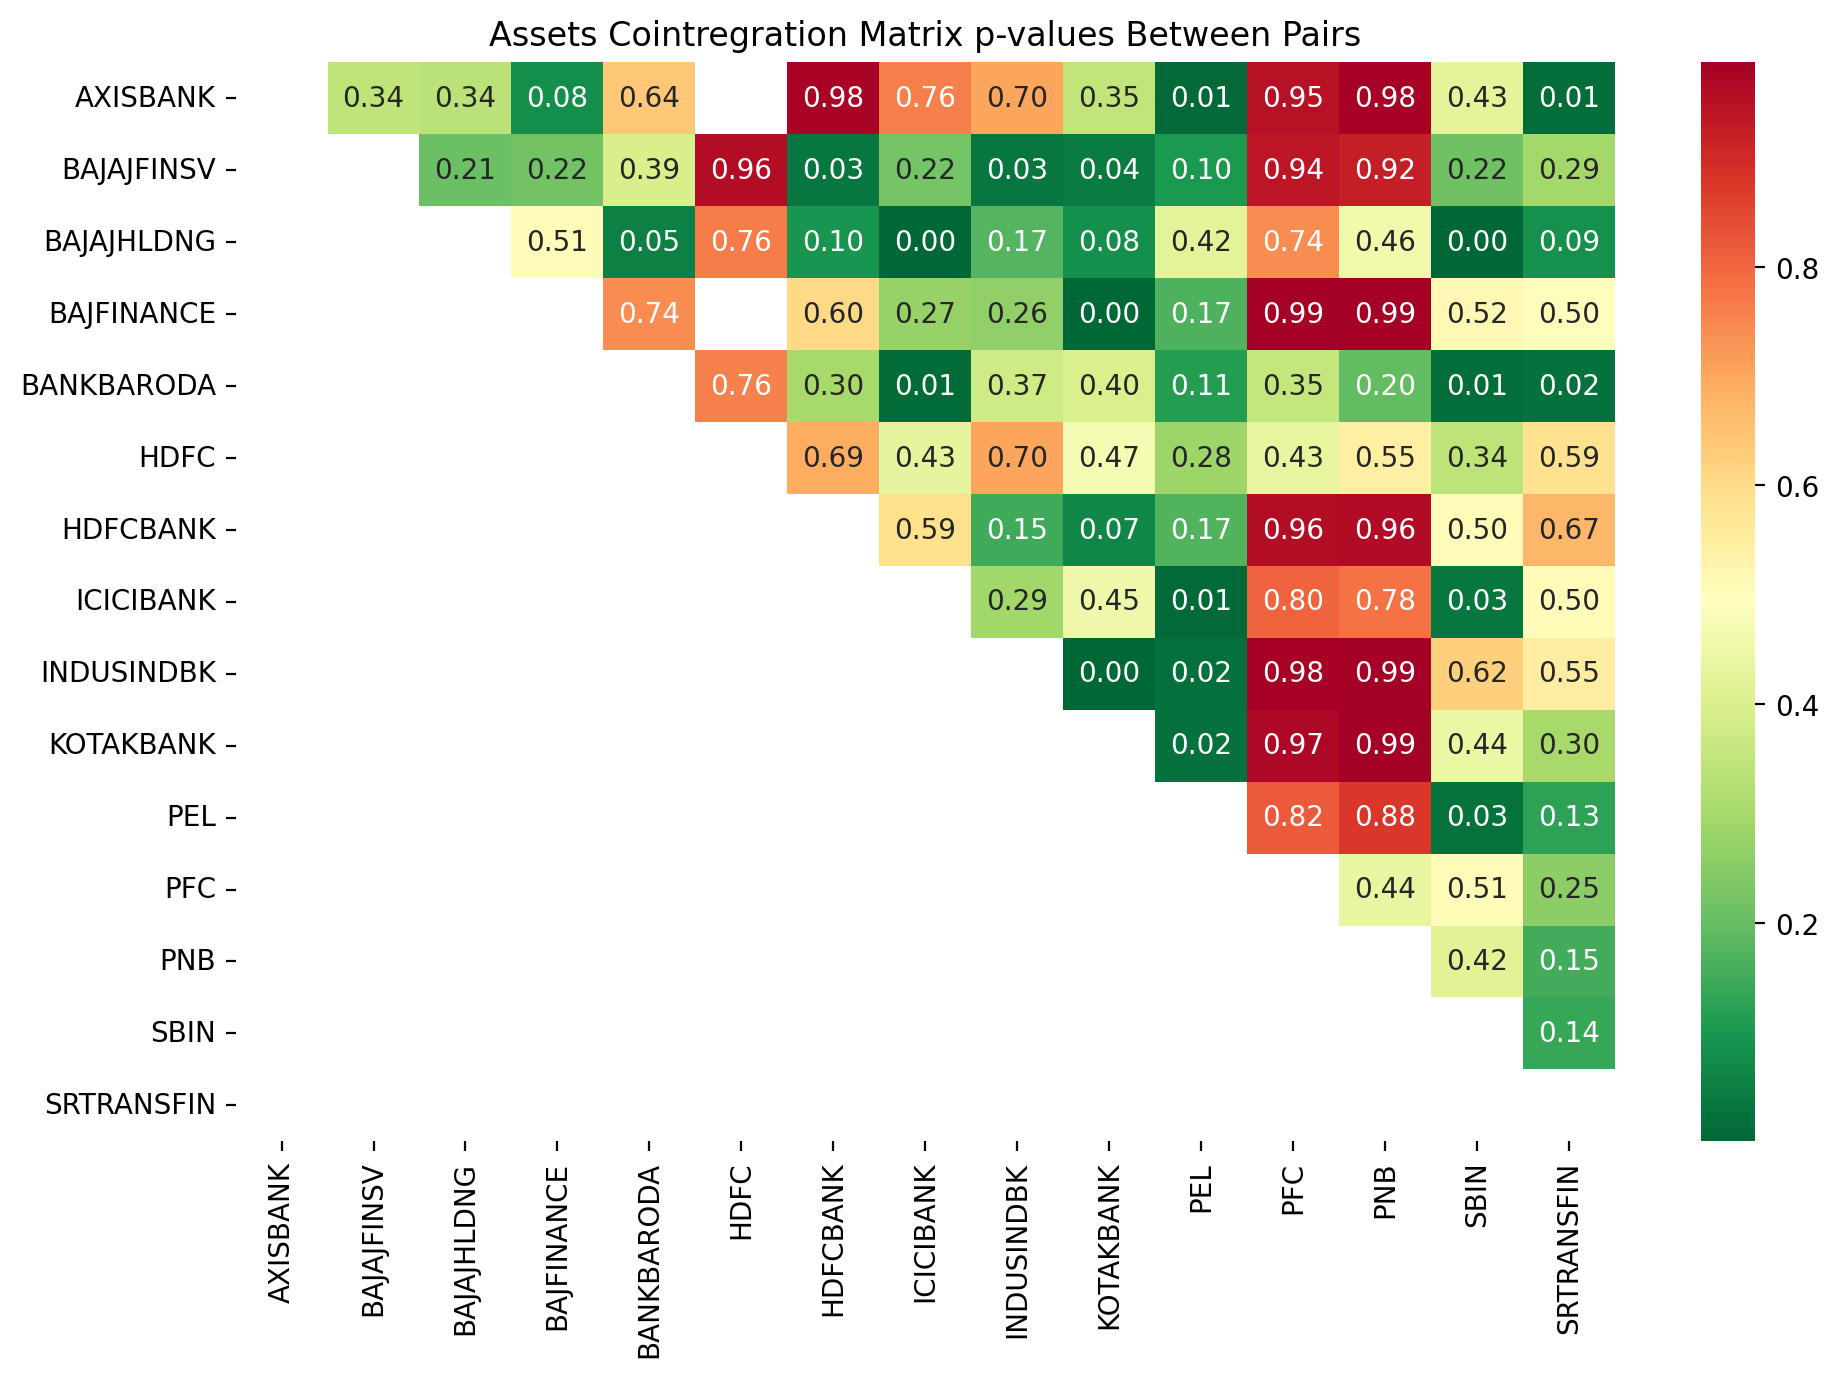

In [39]:
# рассчитываем p-значения и строим в виде тепловой карты
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns, yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",mask = (pvalues >= 0.99))
ax.set_title('Assets Cointregration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('images/chart2', dpi=300)

###################### Part 2 ##############################

In [40]:
# последняя пара для тестирования
asset1 = 'BANKBARODA'
asset2 = 'SBIN'

In [41]:
# создаем фрейм данных поезда из 2 ассетов
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

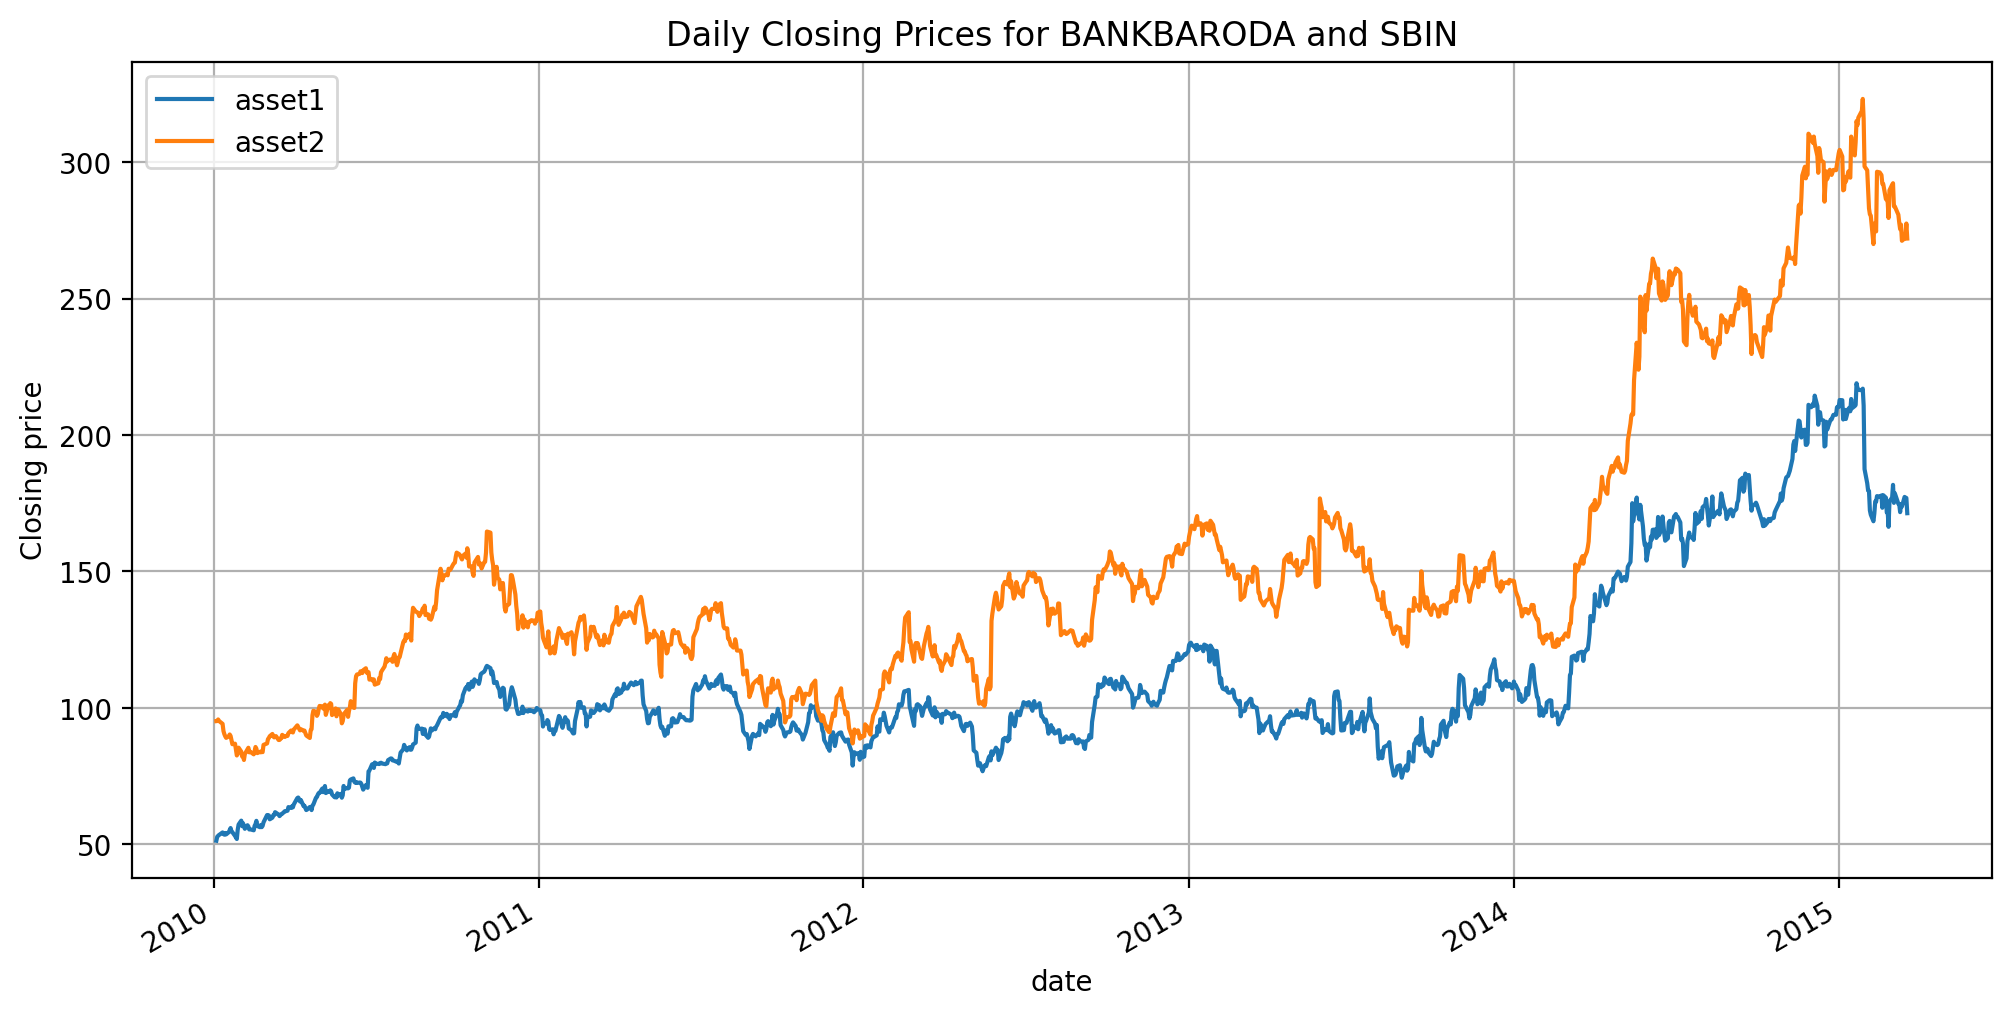

In [42]:
# визуализировать цены закрытия
ax = train[['asset1','asset2']].plot(figsize=(12, 6), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing price")
ax.grid(True)
plt.savefig('images/chart3.png', dpi = 300)

In [43]:
# запустить регрессионную
model = sm.OLS(train.asset2, train.asset1).fit()

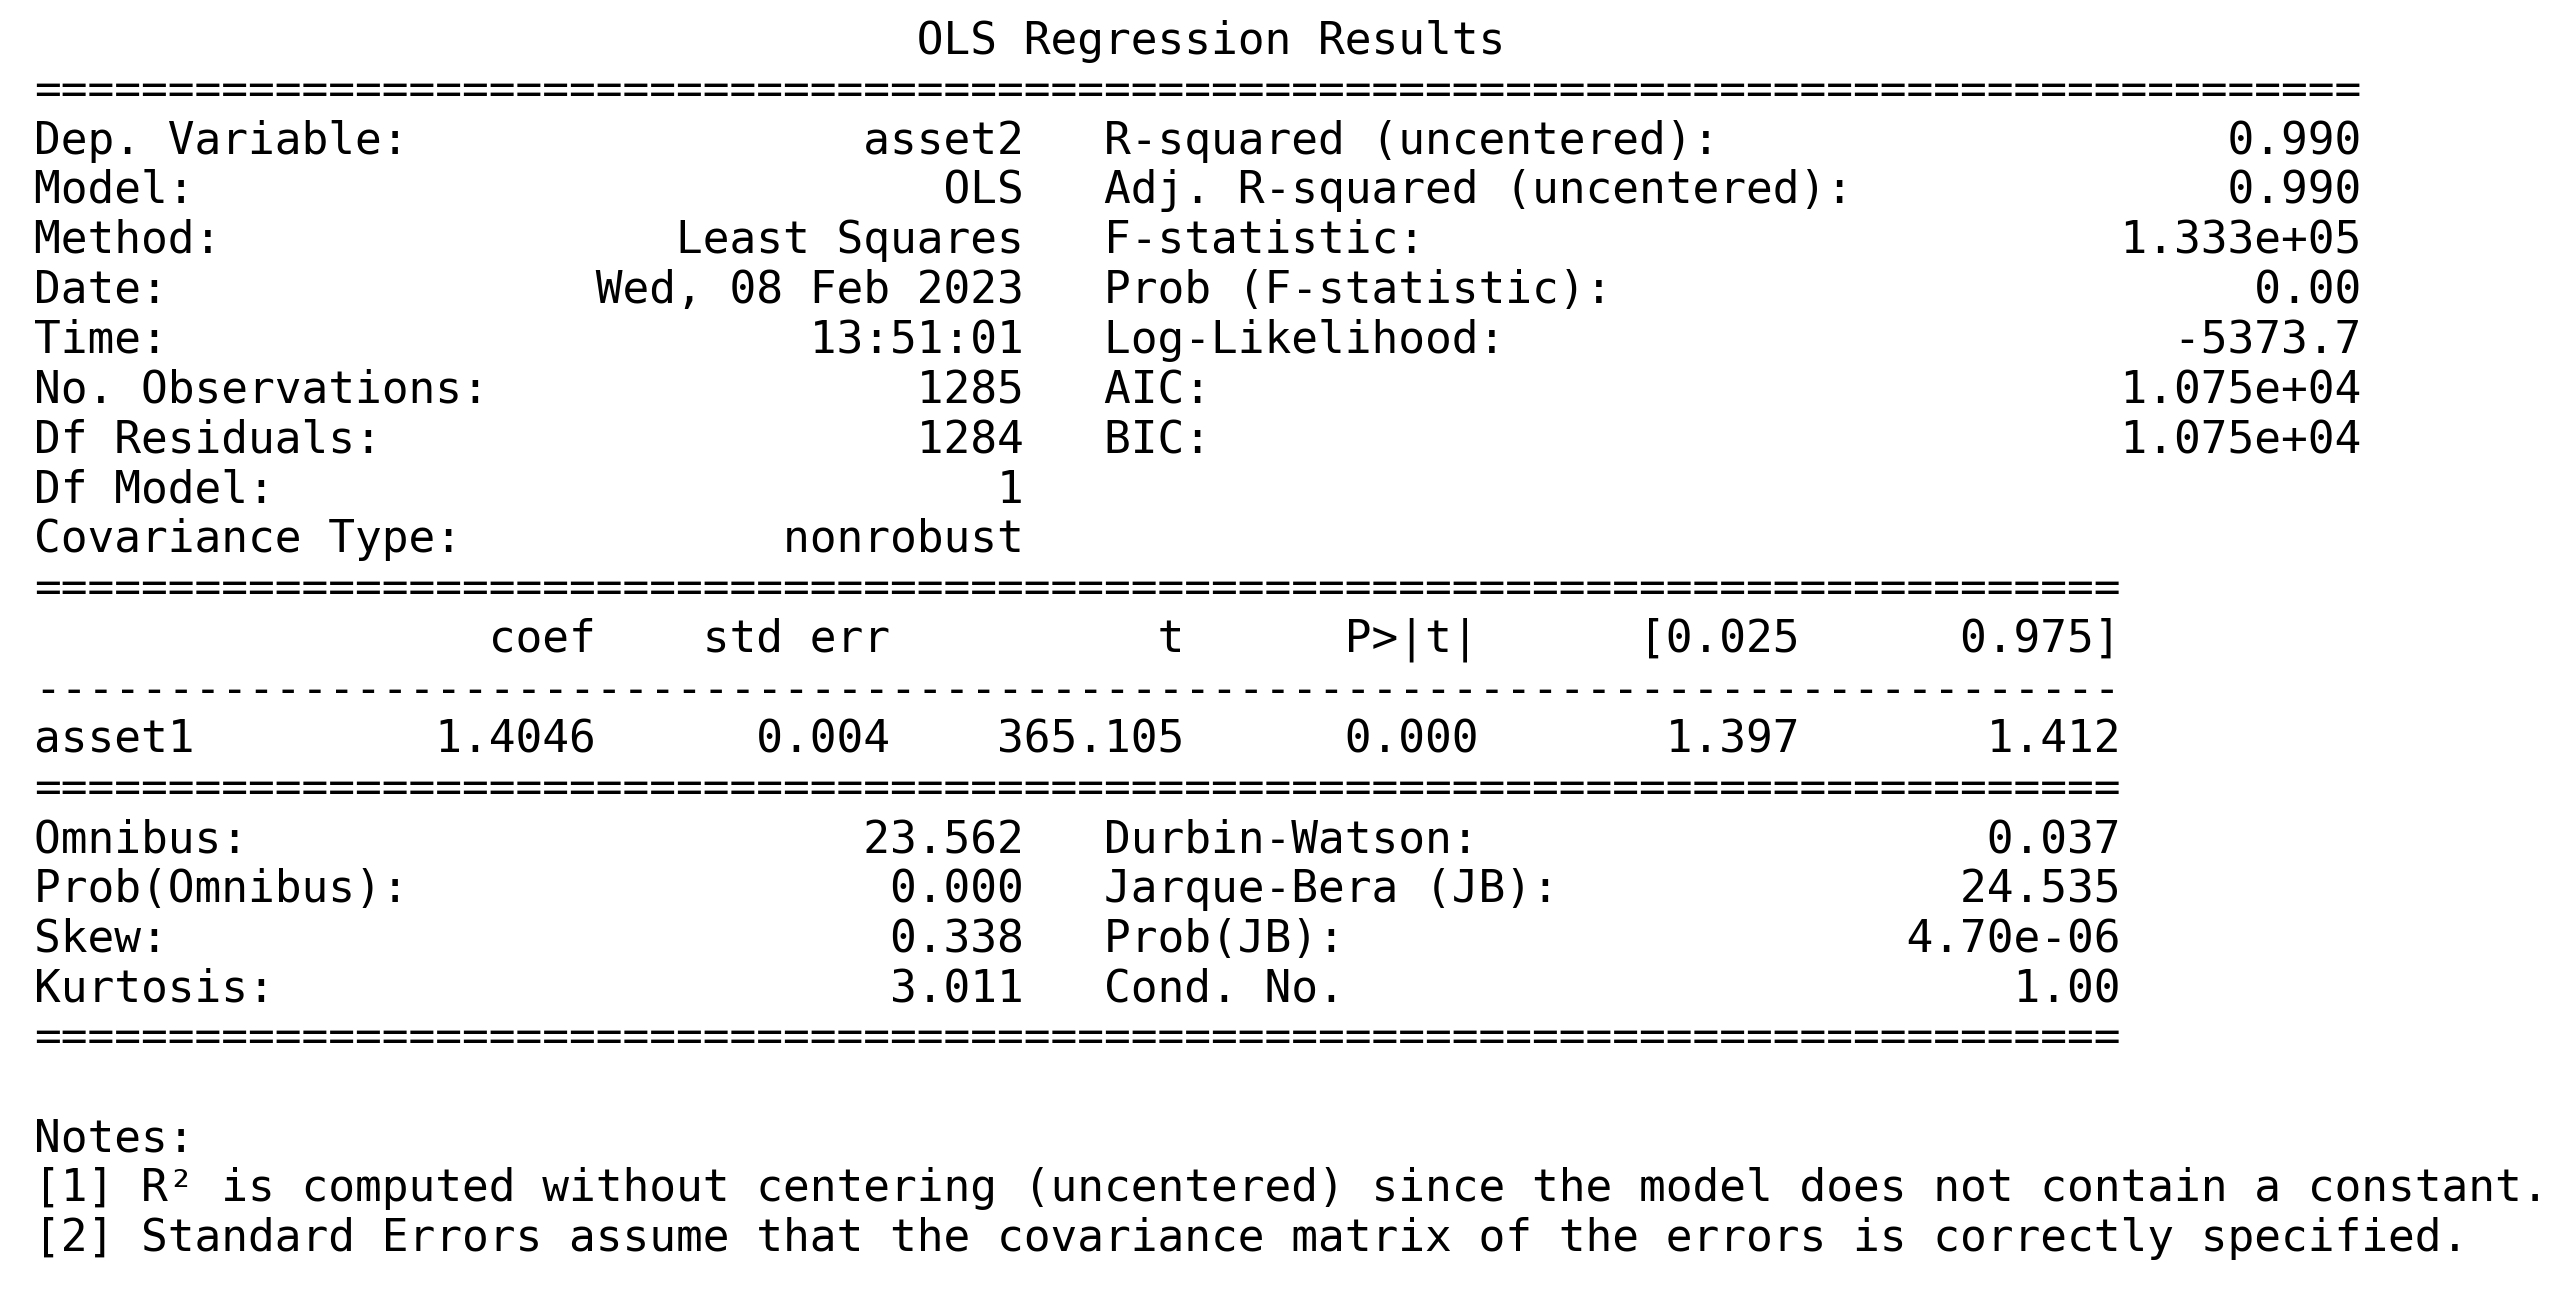

In [44]:
# вывести сводные результаты регрессии
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('images/chart4', dpi=300)

In [45]:
print('Коэффициент хеджирования = ', model.params[0])

Коэффициент хеджирования =  1.4046459680586496


In [46]:
# рассчитать спред
spread = train.asset2 - model.params[0] * train.asset1

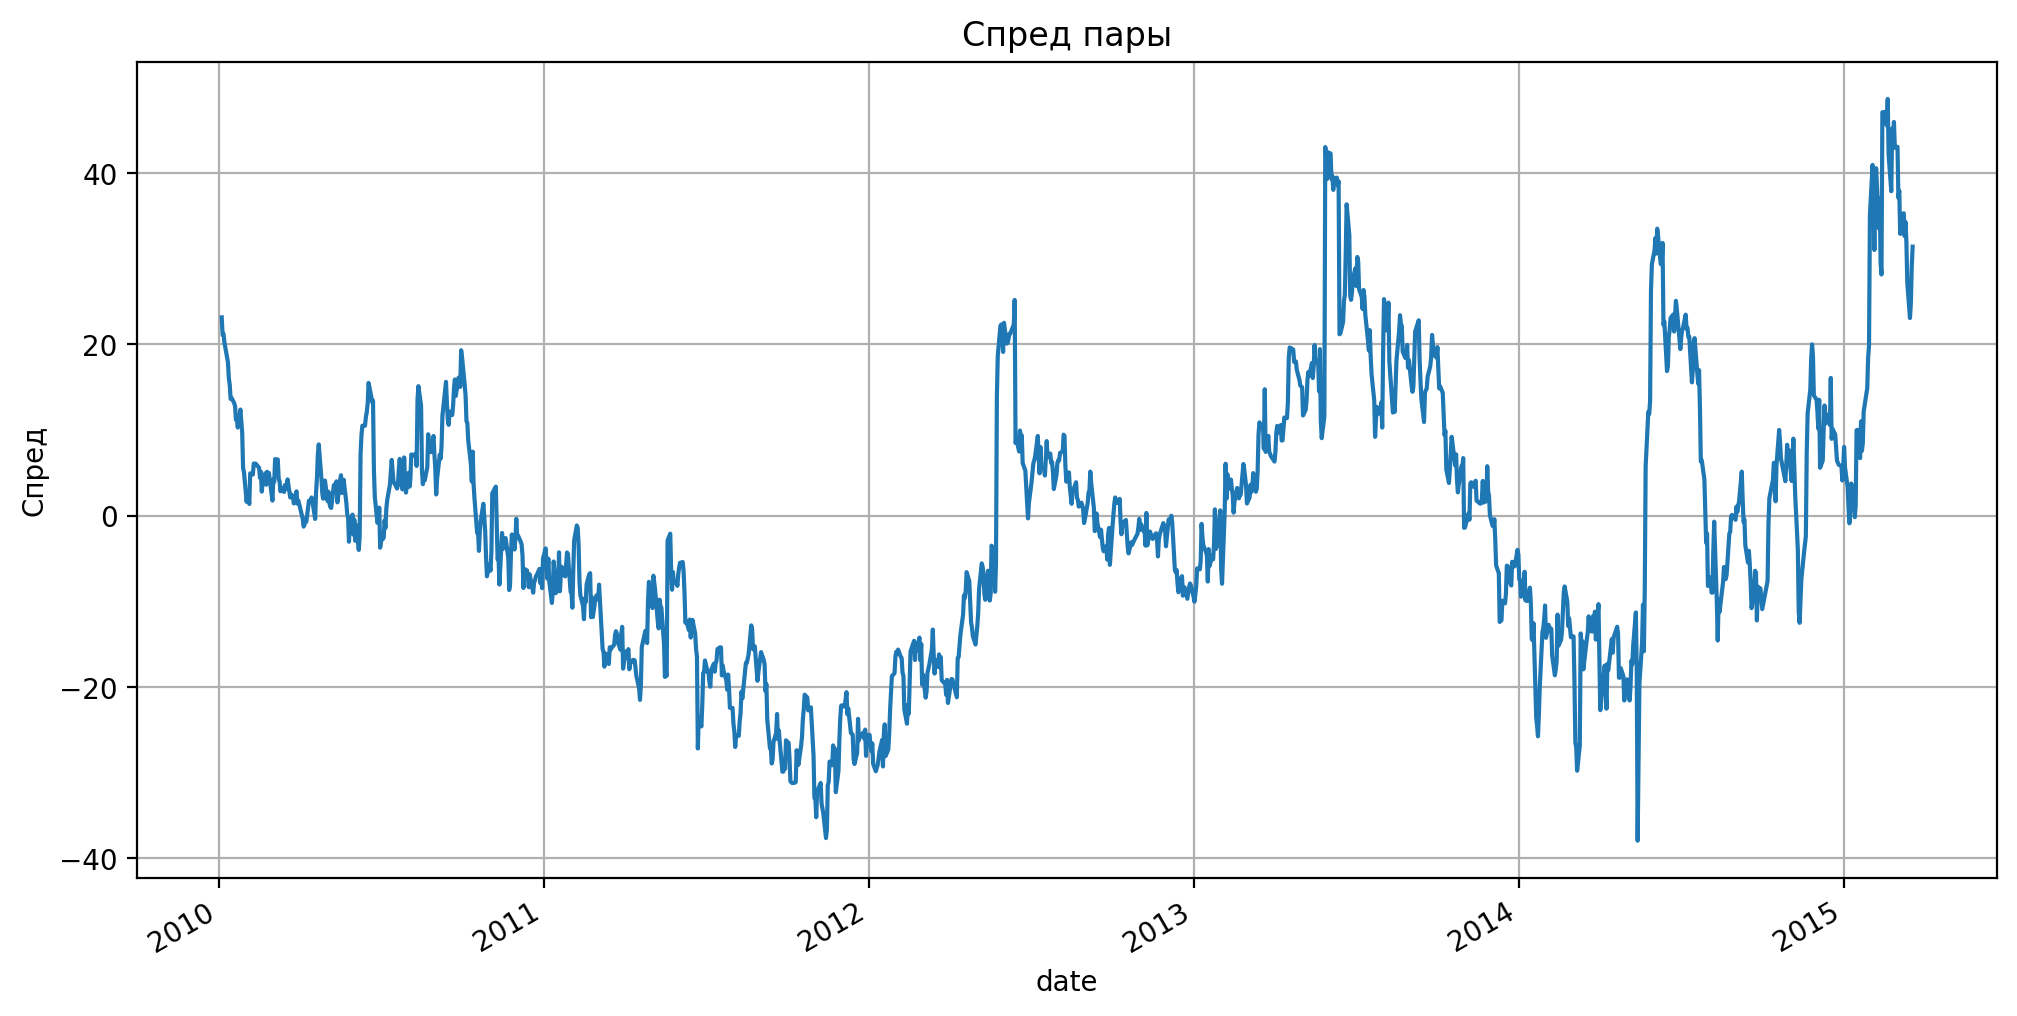

In [48]:
# Построить спред
ax = spread.plot(figsize=(12, 6), title = "Спред пары")
ax.set_ylabel("Спред")
ax.grid(True)
plt.savefig('images/chart5', dpi=300)

In [49]:
# провести расширенный тест Дики-Фуллера
adf = adfuller(spread, maxlag = 1)
print('Critical Value = ', adf[0])

Critical Value =  -3.459047644292159


In [50]:
# критические значения вероятности
print(adf[4])

{'1%': -3.435457117423131, '5%': -2.863795358068796, '10%': -2.567970771161219}
